# 2024 最新cninfo报告下载与词频分析！

### 安装需要的库

In [ ]:
%conda install -c conda-forge pandas requests tqdm selenium==3.141.0 urllib3==1.26.2 textract matplotlib -y

### 1.自行准备需要分析的企业代码

In [1]:
import pandas as pd
import os

if not os.path.exists('output'): os.mkdir('output')
df = pd.read_excel('code.xlsx')                                 # 读取公司代码excel
df['code'] = df['code'].astype(str).apply(lambda x: x.zfill(6)) # 将公司代码转换为6位数文本
df = df.tail(100)                                              # 取末尾5个公司代码
df.head()

,code
5596,600086
5597,600087
5598,600090
5599,600091
5600,600092


### 2.通过抓取企业信息

In [2]:
import requests
 
# 该函数通过已有的公司代码获取org_id，由于下文拼接url
def get_org_id(code):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    }                                                                                               # 设置请求头

    org_id_url = "http://www.cninfo.com.cn/new/information/topSearch/query"                         # 抓取组织信息的url前缀
    org_id_data = {
        "keyWord": code,
        "maxNum": "10",
    }                                                                                               # 请求参数
    
    org_id_response = requests.post(url=org_id_url, data=org_id_data, headers=headers).json()       # 使用post发起请求并获取响应
    for data in org_id_response:
        return data['orgId'], data['pinyin'], data['zwjc'], data['category']                        # 返回第一个符合条件的公司信息
    return None * 4

In [3]:
from tqdm import tqdm
tqdm.pandas() # 给任务加上进度条，进度条在动我就能摸鱼

df['org_id'], df['pinyin'], df['zwjc'], df['category'] = zip(*df['code'].progress_apply(get_org_id))

df.to_excel('output/01_with_org_id.xlsx', index=False)
df.head()

100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


,code,org_id,pinyin,zwjc,category
5596,600086,gssh0600086,tsjy,退市金钰,A股
5597,600087,gssh0600087,tscy,退市长油,A股
5598,600090,gssh0600090,tsjt,退市济堂,A股
5599,600091,gssh0600091,tsmk,退市明科,A股
5600,600092,gssh0600092,sstjm,S*ST精密,A股


In [4]:
# 目标url范例: http://www.cninfo.com.cn/new/disclosure/stock?stockCode=001368&orgId=9900046506#latestAnnouncement

# 该函数合成最新公告url
def get_latest_announcement_url(code, org_id):
    latest_announcement_url = "http://www.cninfo.com.cn/new/disclosure/stock"
    return f"{latest_announcement_url}?stockCode={code}&orgId={org_id}#latestAnnouncement"

# 开始拼接，这一步最快了!
df["latest_announcement_url"] = df.progress_apply(lambda x: get_latest_announcement_url(x["code"], x["org_id"]), axis=1)
df.to_excel("output/02_with_announcement_url.xlsx")
df.head()

100%|██████████| 100/100 [00:00<00:00, 73314.18it/s]


,code,org_id,pinyin,zwjc,category,latest_announcement_url
5596,600086,gssh0600086,tsjy,退市金钰,A股,http://www.cninfo.com.cn/new/disclosure/stock?...
5597,600087,gssh0600087,tscy,退市长油,A股,http://www.cninfo.com.cn/new/disclosure/stock?...
5598,600090,gssh0600090,tsjt,退市济堂,A股,http://www.cninfo.com.cn/new/disclosure/stock?...
5599,600091,gssh0600091,tsmk,退市明科,A股,http://www.cninfo.com.cn/new/disclosure/stock?...
5600,600092,gssh0600092,sstjm,S*ST精密,A股,http://www.cninfo.com.cn/new/disclosure/stock?...


### 3.获取报告页面数量与下载地址

In [10]:
from selenium import webdriver

# 该函数控制浏览器，获取每则公告的访问链接
def fetch_url(code, url, driver):
    driver.get(url)
    # 先看看需要抓几页的内容
    items = driver.find_element_by_class_name("total-box").text     # 页数存在class为total-box的内容中
    items = int(items[1:-1].strip())                                # 从"共xxx条"中掐头去尾
    pages = items // 30 + 1 

    announcements = []
    # 从第一页开始
    for page in range(pages):
        # 获取当前页面所有公告
        items = driver.find_elements_by_class_name("el-table__row")
        # 对每一则公告
        for i in items:
            # 获取公告的时间、标题、文件名、链接
            try:
                href = i.find_element_by_class_name("ahover").get_attribute("href")
                time = href.split("=")[-1][:10]
                # time = i.find_element_by_class_name("time").text[:10]
                # 此处可以对时间进行判断，例如2010年开始不再抓取公告
                title = i.find_element_by_class_name("r-title").text
                file_name = i.find_element_by_class_name("ahover").get_attribute("data-id")
                announcements.append((code, time, title, file_name, href))
            except:
                pass
        if page < pages - 1:
            try:
                driver.find_element_by_class_name("btn-next").click()  # 如果不是最后一页，点击下一页按钮
            except:
                continue
    return announcements

In [ ]:
# 中断继续
import pandas as pd
import os
from tqdm import tqdm
df = pd.read_excel("output/02_with_announcement_url.xlsx")

# # 开启无头模式
# options = webdriver.ChromeOptions()
# options.add_argument('--headless')
# options.add_argument('--disable-gpu')
# driver = webdriver.Chrome(options=options)
# driver.implicitly_wait(10)

# 有界面模式
driver = webdriver.Chrome()
driver.implicitly_wait(10)

# 创建存储每条公告信息的dataframe
if not os.path.exists("output/03_announcements"):
    os.makedirs("output/03_announcements")
    
completed_codes = list()
for file_name in os.listdir("output/03_announcements"):
    if file_name.endswith(".csv"):
        code = int(file_name.split(".")[0])
        completed_codes.append(code)

try:
    count, break_count = 0, 100 # 小试牛刀，先爬100个
    # 此处可以考虑使用多线程提高效率
    for index, row in tqdm(df.iterrows(), total=len(df)):
        if count == break_count:
            break
        else:
            count += 1
        if int(row["code"]) in completed_codes: continue # 跳过已完成的公告
        code, url = row["code"], row["latest_announcement_url"]
        announcements = fetch_url(code, url, driver)
        announcements_list = pd.DataFrame(announcements, columns=["code", "time", "title", "file_name", "href"])
        announcements_list.drop_duplicates(subset=["file_name"], inplace=True) # 去重
        announcements_list.to_csv(f"output/03_announcements/{code}.csv", index=False)
except Exception as e:
    print(e)
    driver.quit()

driver.quit()

### 4.下载报告进入announcements文件夹

In [18]:
import os
from selenium import webdriver
import time

download_path = os.path.abspath("downloads")
if not os.path.exists(download_path): os.makedirs(download_path)

preferences = {
    "download.default_directory": download_path,
    "plugins.always_open_pdf_externally": False,
}

chrome_options = webdriver.ChromeOptions()
chrome_options.add_experimental_option("prefs", preferences)

# 该函数通过公告的url下载公告
def download_file(url, driver):
    driver.get(url)
    # time.sleep(0.01)
    # final_url = driver.current_url  # 获取跳转后的URL
    while driver.current_url.startswith("s"):
        return driver.current_url
    # return final_url



In [19]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

driver = webdriver.Chrome(options=chrome_options)
driver.implicitly_wait(10)

company_list = os.listdir("output/03_announcements") # 读取不同公司的公告列表
company_list = [file for file in company_list if file.endswith(".csv")]

for file in tqdm(company_list):
    df = pd.read_csv(f"output/03_announcements/{file}") 
    df['direct_link'] = df.progress_apply(lambda x: download_file(x['href'], driver), axis=1)

df.head()

  0%|          | 0/1 [00:00<?, ?it/s]

Processing 600086.csv...


100%|██████████| 1/1 [12:54<00:00, 774.08s/it]


,code,time,title,file_name,href,direct_link
0,600086,2021-03-12,退市金钰：东方金钰股份有限公司关于财务总监辞职及聘任财务总监、董事会秘书及副总裁的公告,1209370824,http://www.cninfo.com.cn/new/disclosure/detail...,None
1,600086,2021-03-12,退市金钰：东方金钰股份有限公司关于监事辞职、罢免监事及选举产生监事的公告,1209370823,http://www.cninfo.com.cn/new/disclosure/detail...,None
2,600086,2021-03-12,退市金钰：东方金钰股份有限公司关于公司控股股东及其关联方资金占用情况的提示性公告,1209370822,http://www.cninfo.com.cn/new/disclosure/detail...,None
3,600086,2021-03-12,退市金钰：东方金钰股份有限公司关于拟聘请代办机构的公告,1209370821,http://www.cninfo.com.cn/new/disclosure/detail...,None
4,600086,2021-03-12,退市金钰：东方金钰股份有限公司第九届董事会第二十一次会议决议公告,1209370820,http://www.cninfo.com.cn/new/disclosure/detail...,None


In [ ]:
import pandas as pd
from tqdm import tqdm

driver = webdriver.Chrome(options=chrome_options)
driver.implicitly_wait(10)

company_list = os.listdir("output/03_announcements") # 读取不同公司的公告列表

completed_list = [int(file_name.split(".")[0]) for file_name in os.listdir("downloads")]
completed_list = set(completed_list)

# 此处下载也可以用多线程，上限取决于你的网络带宽
for file_name in tqdm(company_list):
    file_path = os.path.join("output/03_announcements", file_name)
    company = pd.read_csv(file_path)
    for index, row in company.iterrows():
        if int(row["file_name"]) in completed_list: continue
        download_file(row["href"], driver)

driver.quit()

### 5.读取报告并进行词频分析

In [59]:
import os
import textract

# 计算关键词在PDF中出现次数
def count_keywords(keywords, pdf):
    if os.path.exists(pdf):
        text = ""
        try:
            text = textract.process(pdf).decode("utf-8")
        except:
            return 0
        count = 0
        for keyword in keywords:
            count += text.count(keyword)
        return count
    return 0

In [74]:
download_path = "downloads"

keywords = ['数字化']

announcements_list["count"] = announcements_list["file_name"].progress_apply(lambda x: count_keywords(keywords, os.path.join(download_path, f"{x}.pdf")))


100%|██████████| 1751/1751 [02:04<00:00, 14.02it/s]


In [75]:
announcements_list['year'] = announcements_list['time'].apply(lambda x: x.split('-')[0])
announcements_list.head()

,code,time,title,file_name,href,count,year
0,002582,2024-03-02,好想你：关于回购公司股份进展情况的公告,1219219898,http://www.cninfo.com.cn/new/disclosure/detail...,0,2024
1,002582,2024-02-08,好想你：关于控股股东部分股份补充质押的公告,1219132810,http://www.cninfo.com.cn/new/disclosure/detail...,0,2024
2,002582,2024-02-08,好想你：关于回购股份事项前十名股东及前十名无限售条件股东持股情况的公告,1219123886,http://www.cninfo.com.cn/new/disclosure/detail...,0,2024
3,002582,2024-02-08,好想你：关于回购公司股份比例达到1%的进展公告,1219123885,http://www.cninfo.com.cn/new/disclosure/detail...,0,2024
4,002582,2024-02-07,好想你：关于首次回购公司股份暨回购进展的公告,1219110950,http://www.cninfo.com.cn/new/disclosure/detail...,0,2024


In [76]:
grouped = announcements_list.groupby(['code', 'year'])['count'].sum().reset_index()
grouped


,code,year,count
0,002582,2011,0
1,002582,2012,0
2,002582,2013,0
3,002582,2014,0
4,002582,2015,0
5,002582,2016,13
6,002582,2017,10
7,002582,2018,11
8,002582,2019,16
9,002582,2020,18


### 6.保存结果

In [77]:
announcements_list.to_csv("announcements.csv", index=False)
grouped.to_csv("grouped.csv", index=False)

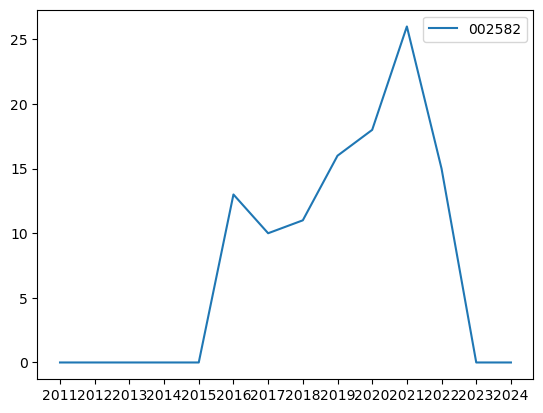

In [78]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for code in grouped['code'].unique():
    data = grouped[grouped['code'] == code]
    ax.plot(data['year'], data['count'], label=code)
ax.legend()
plt.show()